 <font size = +3.5><b><u><center> Phase 2 Project Notebook </center></u></b></font>

# Business Understanding

 * As a Construction Consulting firm, Royal Advisory helps new home renovation businesses establish themselves in the Seattle market.
 <br>  
  
  * With the housing market is cooling rapidly in Seattle, homeowners are increasingly opting to invest in remodeling their current home instead of buying new properties. Given this [increase in demand](https://www.king5.com/article/money/markets/real-estate/seattle-home-renovation-housing-cooldown/281-71cb28a8-1bd5-4187-955f-debad072fe53), now is the perfect time for a home renovation company to move into the Seattle area. 
  <br>  
  
  * A new home renovation company, Home Remedies, hired us to recommend the best services to offer to clients looking to increase the sale value of their homes. 
 <br>

## Types of Remodeling Projects

 * First, based on [industry definitions](https://www.homeadvisor.com/cost/additions-and-remodels/), we identifed three major components of home remodeling projects:
     1. **Home Renovations:** Updating the quality of the house's building material
     2. **Home Remodeling:** Increasing the size of your home, either through extensions or additions:
         2a. **Home Extensions:** Increasing the size of existing section of the house
         2b. **Home Additions:** Adding a new section to your home
     
 * We were then guided by these business questions:

## Business Questions: 

1. For all clients interested in home remodeling (increasing the area of your house, either through *home extensions* or *home additions*, where are the best areas to add square footage?
    - Which areas of the house is increased area associated with increased sale value?
    - Our model included these common home spaces: Above-Ground Living Space (e.g. rooms, kitchen, hallways), Basement, Garage, Patio, Yard

<br> 

2. For clients specifically interested in *home additions*, what are the best structures to add to increase the sale value of their house?
    - What types of home additions contribute to a higher sale price?
    
<br>  
    
3. How much do renovations contribute to the sale price of a house? Should clients add build quality renovation projects to their home remodeling projects to increase their house's value?
<br>  

***

## Data Source & Relevance to Business Case

<font color = green><b><u> Rubric: Data Understanding pt 1 </u></b>
    
1. Describe the data sources and explain why the data are suitable for the project
2. Present the size of the dataset </font>

* Data from King County: all house sale in 2021 (n = 30155)

* Current data allows us to see what *features of a house* contributed to house sale price in 2021
   * From this, we can infer what types of house changes could increase future house sale price

# Data Preparation

<font color = green><b><u> Rubric: Data Preparation </u></b></font>

1. Instructions or code needed to get and prepare the raw data for analysis
2. Code comments and text to explain what your data preparation code does
3. Valid justifications for why the steps you took are appropriate for the problem you are solving

## Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
# Collect entire data 

data = pd.read_csv('data/kc_house_data.csv')

## Exploring Variables in Dataset

In [3]:
# Checkout all data columns & spot Null values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

## Identifying Features of Interest to Answer Current Questions

<font color = green><b><u> Rubric: Data Understanding pt2 </u></b>
    
2. descriptive statistics for all features used in the analysis
3. Justify the inclusion of features based on their properties and relevance for the project </font>

Features of Interest for each question:
<br>
<font color = red> Include here </font>

### Columns to Exclude

* First, we excluded variables that a home remodeling company *could not change* -- not useful information for our client
* Second, we excluded the "Condition" variable
    * King County Definition: "Condition is relative to age and grade"
    * Would repeat the effect of one of our key variables (grade)
    * Since grade refers to "construction build and quality," it is more relevant to our client
* Third, we excluded Heat Source & Sewer System variables because they are outside of the scope of the services Home Remedies can offer. Home Remedies generally refers clients who are interested in such projects to external Energy Consultants or Plumbers.

<font color = blue> <b> Move to Conclusion Section: </b>
    <br>  
    * Some of these variables could account for price valuation (such as location) <br>  
    * In future analyses, we could improve our models by including some of these as control variables </font>

In [4]:
# Dropping columns not related to current questions/analyses

df = data.drop(['id', 'date', 'view', 'waterfront', 'greenbelt', 'nuisance', 
                'condition', 'yr_built','yr_renovated', 'heat_source', 'sewer_system','address', 'lat', 'long'], axis=1)

In [5]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'grade', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio'],
      dtype='object')

In [6]:
# Excluding Condition: the King County glossary notes that Condition rating is "relative to age and grade"
    # Repetitive, since we are already looking at Grade
    # Grade is more directly relevant to Home Renovating company, since it refers to "construction build and quality of materials"
    

### Calculating Features of Interest not yet present in dataset

Yard Space: calculating based on [architect definitions](https://www.yourownarchitect.com/what-is-the-difference-between-floor-area-and-lot-area/)

Yard Space = Lot Space - (Ground Floor Living Space + Patio Space + Garage Space)

However, living space can be larger than lot space if there are multiple floors. We need to determine the space that only the ground floor takes up. Estimated using this formula:
(Sqft_living / floors)

In [7]:
df['sqft_yard'] = df['sqft_lot'] - (df['sqft_living']/df['floors'] + df['sqft_garage'] + df['sqft_patio'])

Presence of Basement/Garage/Patio: binary variables (Y/N)

* For the house additions analysis, we want to compare houses that have these features compared to houses that do not. 
For garage and patio, we need to derive this information from the sq_ft variable:

In [8]:
# Changing basement, patio, and garage to binary
# 1 (YES) the property has one or 0 (NO) the property does not have one

df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
df['has_garage'] = df['sqft_garage'].apply(lambda x: 1 if x > 0 else 0)
df['has_patio'] = df['sqft_patio'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'grade', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
       'sqft_yard', 'has_basement', 'has_garage', 'has_patio'],
      dtype='object')

## Cleaning Variables

In [10]:
#For graph visibility, making Grade into a new, numeric-only variable (grade_num)

orig_grade_val = list(df['grade'].value_counts().index)
orig_grade_val
new_grade_val = [7, 8, 9, 6, 10, 11, 5, 12, 4, 13, 3, 1, 2]

df['grade_num'] = df['grade'].replace(orig_grade_val, new_grade_val)

In [11]:
# Might be helpful to have a grade_dict matching num to definition

grade_dict = {new_grade_val[i]: orig_grade_val[i].strip('0123456789.- ') for i in range(len(new_grade_val))}

grade_dict
df['grade'] = df['grade_num']

df.drop('grade_num',axis=1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,sqft_yard,has_basement,has_garage,has_patio
0,675000.0,4,1.0,1180,7140,1.0,7,1180,0,0,40,5920.000000,0,0,1
1,920000.0,5,2.5,2770,6703,1.0,7,1570,1570,0,240,3693.000000,1,0,1
2,311000.0,6,2.0,2880,6156,1.0,7,1580,1580,0,0,3276.000000,1,0,0
3,775000.0,3,3.0,2160,1400,2.0,9,1090,1070,200,270,-150.000000,1,1,1
4,592500.0,2,2.0,1120,758,2.0,7,1120,550,550,30,-382.000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,1555000.0,5,2.0,1910,4000,1.5,8,1600,1130,0,210,2516.666667,1,0,1
30151,1313000.0,3,2.0,2020,5800,2.0,7,2020,0,0,520,4270.000000,0,0,1
30152,800000.0,3,2.0,1620,3600,1.0,7,940,920,240,110,1630.000000,1,1,1
30153,775000.0,3,2.5,2570,2889,2.0,8,1830,740,480,100,1024.000000,1,1,1


## Descriptive Statistics on Variables

In [ ]:
df.desc

### Outcome: Price

count    3.015500e+04
mean     1.108536e+06
std      8.963857e+05
min      2.736000e+04
25%      6.480000e+05
50%      8.600000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64


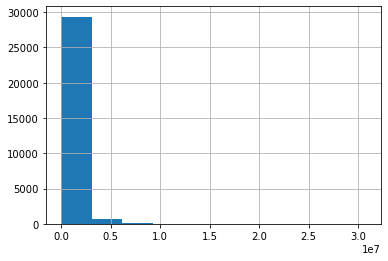

In [12]:
print(df['price'].describe())
df['price'].hist();

In [13]:
# Data is highly skewed right (large positive outliers)
# Need to remove outliers

### Predictors: Categorical Variables

In [14]:
df['grade'].value_counts()

7     11697
8      9410
9      3806
6      2858
10     1371
11      406
5       393
12      122
4        51
13       24
3        13
2         2
1         2
Name: grade, dtype: int64

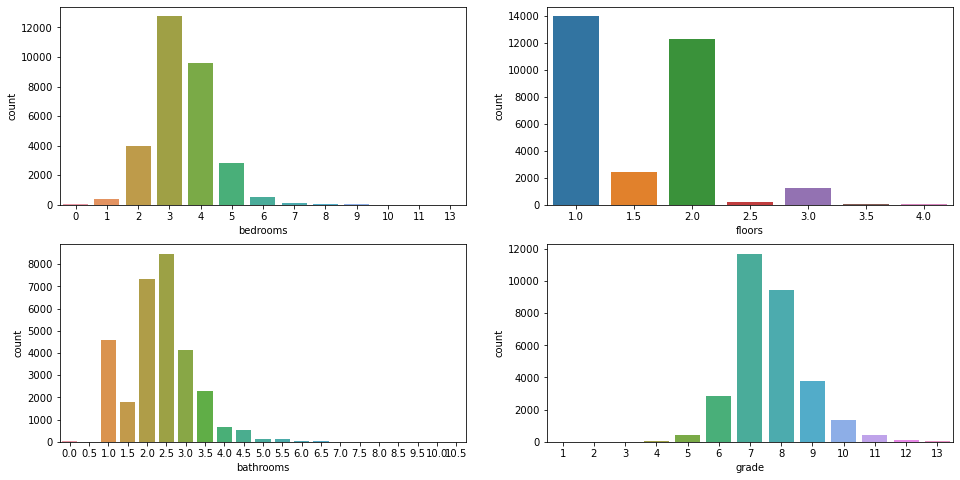

In [15]:
cat = ['bedrooms', 'bathrooms', 'floors', 'grade']
df_cat = df[cat] 

fig, ax = plt.subplots(2, 2, figsize=(16,8))

for i, col in enumerate(df_cat.columns):
    x = i%2
    y = i//2
    sns.countplot(x=col, data=df_cat, ax=ax[x][y])

In [16]:
# Significant Outliers in Bedrooms, Bathrooms, Grade & Floors -- need to exclude or combine categories

### Predictors: Binary Variables

### Predictors: Continuous Variables

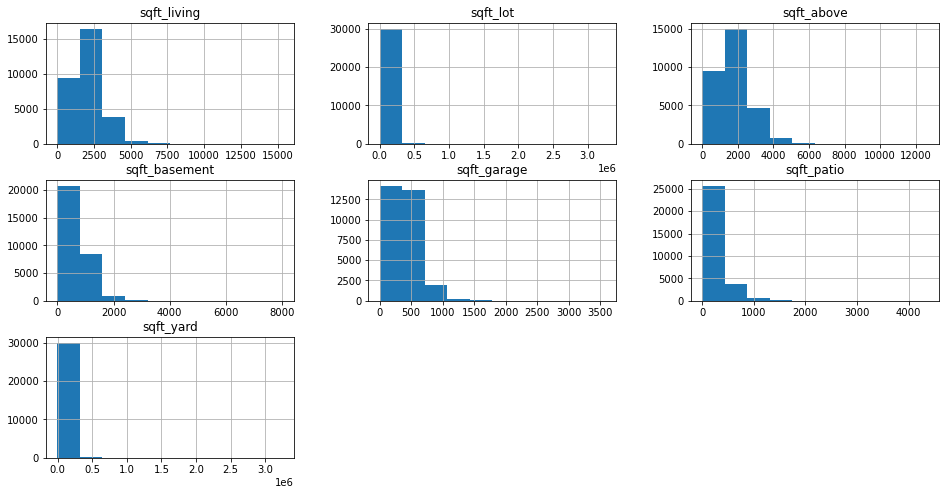

In [17]:
cont = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio','sqft_yard']

plt
df[cont].hist(figsize=(16,8));

In [18]:
# All of these variables are heavily skewed left
# Might be beneficial to transform 

## Defining & Excluding Outliers

* We want to look at typical qualities of houses: only cases relevant to our client
    * Data indicates many outliers: 
        * Rare to encounter these clients with houses fitting these cases
        * Likely to have different goals/priorities than target audience

### Categorical Ordinal Variables: Dropping Outliers

* For all categorical ordinal variables (Bathroom, Bedroom, Floors, Grade): we excluded any group with n < 100.

In [19]:
df['bedrooms'].value_counts()

df_clean = df[(df['bedrooms'] != 0) & (df['bedrooms'] < 7)]

In [20]:
df['bathrooms'].value_counts()

df = df[(df['bathrooms'] >= 1) & (df['bathrooms'] < 6)]

df['bathrooms'].value_counts()

2.5    8475
2.0    7349
1.0    4576
3.0    4117
3.5    2266
1.5    1808
4.0     645
4.5     533
5.0     145
5.5     104
Name: bathrooms, dtype: int64

In [21]:
df['floors'].value_counts()

df_clean = df[df['floors'] <= 3]



In [22]:
df['floors'].value_counts()

df_clean = df[df['floors'] <= 3]

In [23]:
df['grade'].value_counts() 
# Based on n < 100 rule, can exclude 1, 2, 3, 4, 12, 13

df = df[(df['grade'] > 4) & (df['grade'] < 12)]

df.grade.value_counts().sort_index()


5       391
6      2857
7     11673
8      9391
9      3795
10     1355
11      384
Name: grade, dtype: int64

#### Condensing grade into 4 categories

After reviewing the King County definitions, we decided to combine similar grades into 4 categories, based on the similar language that each definition used. For the categories labeled as "High Quality," we used the label "Exceptional"

 * 5 & 6 = Below Average
 * 7 = Average
 * 8 & 9 = Above Average
 * 10 & 11 = Exceptional Quality
 

In [40]:
grade_old = [5,6,7,8,9,10,11]
grade_new = ['Below_Average', 'Below_Average', 'Average', 'Above_Average', 'Above_Average', 'Exceptional', 'Exceptional']

df['grade'] = df['grade'].replace(grade_old, grade_new)

df['grade'].value_counts()

df['grade']=pd.Categorical(df['grade'], ordered=True, categories=['Below_Average', 'Average', 'Above_Average','Exceptional'])

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29846 entries, 0 to 30154
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          29846 non-null  float64 
 1   bedrooms       29846 non-null  int64   
 2   bathrooms      29846 non-null  float64 
 3   sqft_living    29846 non-null  int64   
 4   sqft_lot       29846 non-null  int64   
 5   floors         29846 non-null  float64 
 6   grade          29846 non-null  category
 7   sqft_above     29846 non-null  int64   
 8   sqft_basement  29846 non-null  int64   
 9   sqft_garage    29846 non-null  int64   
 10  sqft_patio     29846 non-null  int64   
 11  sqft_yard      29846 non-null  float64 
 12  has_basement   29846 non-null  int64   
 13  has_garage     29846 non-null  int64   
 14  has_patio      29846 non-null  int64   
 15  grade_num      29846 non-null  int64   
dtypes: category(1), float64(4), int64(11)
memory usage: 3.7 MB


### Continous Variables: Dropping Outliers

* To remove outliers from "price" and "sqft_living", we excluded the bottom & top 2.5% of values.

In [44]:
outliers = ['sqft_living','price']

for col in outliers:
    df = df[(df[col] > np.percentile(df[col], .25)) & (df[col] < np.percentile(df[col], 99.75))]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29541 entries, 0 to 30154
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          29541 non-null  float64 
 1   bedrooms       29541 non-null  int64   
 2   bathrooms      29541 non-null  float64 
 3   sqft_living    29541 non-null  int64   
 4   sqft_lot       29541 non-null  int64   
 5   floors         29541 non-null  float64 
 6   grade          29541 non-null  category
 7   sqft_above     29541 non-null  int64   
 8   sqft_basement  29541 non-null  int64   
 9   sqft_garage    29541 non-null  int64   
 10  sqft_patio     29541 non-null  int64   
 11  sqft_yard      29541 non-null  float64 
 12  has_basement   29541 non-null  int64   
 13  has_garage     29541 non-null  int64   
 14  has_patio      29541 non-null  int64   
 15  grade_num      29541 non-null  int64   
dtypes: category(1), float64(4), int64(11)
memory usage: 3.6 MB


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29541 entries, 0 to 30154
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          29541 non-null  float64 
 1   bedrooms       29541 non-null  int64   
 2   bathrooms      29541 non-null  float64 
 3   sqft_living    29541 non-null  int64   
 4   sqft_lot       29541 non-null  int64   
 5   floors         29541 non-null  float64 
 6   grade          29541 non-null  category
 7   sqft_above     29541 non-null  int64   
 8   sqft_basement  29541 non-null  int64   
 9   sqft_garage    29541 non-null  int64   
 10  sqft_patio     29541 non-null  int64   
 11  sqft_yard      29541 non-null  float64 
 12  has_basement   29541 non-null  int64   
 13  has_garage     29541 non-null  int64   
 14  has_patio      29541 non-null  int64   
 15  grade_num      29541 non-null  int64   
dtypes: category(1), float64(4), int64(11)
memory usage: 3.6 MB


In [47]:
print(f"Removed {30155 - 29541} datapoints, which is {(30155-29541)/30155*100: .2f}% of the data")

Removed 614 datapoints, which is  2.04% of the data


We are still well below our rule of thumb of retaining 90% of our datapoints

* For the other sqft_ variables, the above method of removing outliers would remove more than 10% of our data. 
* As a result, we are going to leave the outliers in for now and see how they look after data transformation.

# Modeling

Runs and interprets a simple, baseline model for comparison

Introduces new models that improve on prior models and interprets their results

Explicitly justifies model changes based on the results of prior models and the problem context

Explicitly describes any improvements found from running new models

# Results

Explicitly identify the features and interpret their coefficients in plain language

Explain the implications of results for the real-world problem the project aims to address

Identify specific actions that stakeholders should take to leverage these results
